1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [6]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

183.12


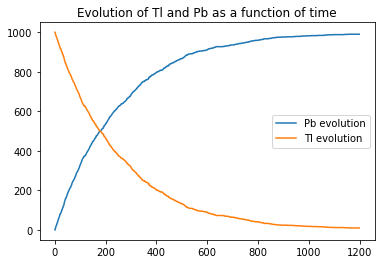

In [2]:
#probability function 
def prob(t):
    tau = 3.052 * 60 #in seconds
    return 1 - 2 **(-t/tau)

#for each time step, decide if Tl atom has decayed
TL_init = 1000
TL_values = []
PB_init = 0
PB_values = []
time = 1200
atoms = np.zeros(TL_init)
dt = 1

TL_decayed = np.zeros(time)
TL_remaining = np.zeros(time)

for time_step in range(time):
    TL_decayed[time_step] = np.sum(atoms == 1)
    TL_remaining[time_step] = np.sum(atoms == 0)
    
    for j in range(TL_init):
        if np.random.random() <= prob(dt):
            if atoms[j] == 0:
                atoms[j] = 1
    
#     TL_new = TL_init - (prob(time_step))*TL_init
#     PB_diff = TL_init - TL_new
#     PB_new = PB_init + PB_diff
#     TL_values.append(TL_new)
#     PB_values.append(PB_new)
#     #reinitialise
#     TL_init = TL_new
#     PB_init = PB_new

print(3.052 * 60)
plt.plot(range(time), TL_decayed, label = 'Pb evolution')
#plt.xscale("log")
plt.plot(range(time), TL_remaining, label = 'Tl evolution')
plt.legend()
plt.title('Evolution of Tl and Pb as a function of time')
plt.show()

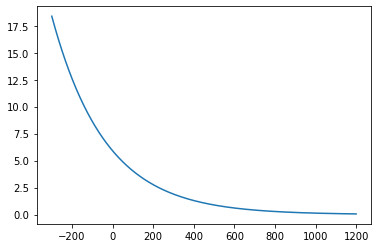

In [82]:
# Repeat the exercise by means of the inverse transform method:
# draw 1000 random numbers from the non-uniform probability 
# distribution  𝑝(𝑡)=2−𝑡/𝜏ln2𝜏  to represent the times of decay 
# of the 1000 Tl atoms. Make a plot showing the number of atoms 
# that have not decayed as a function of time

def pdf(t, tau = 3.052 * 60):
    return 2**(-t/tau) * np.log(2*tau)
   
x = np.linspace(-300,1200,800)
  
plt.plot(x, pdf(x))
#plt.hist(pdf(u), histtype='step', bins=100, density = True, linewidth=2)
plt.show()    
#1000 numbers between 0 and 1200 for decay times
points = np.random.uniform(0,1200,1000)
times = pdf(points)


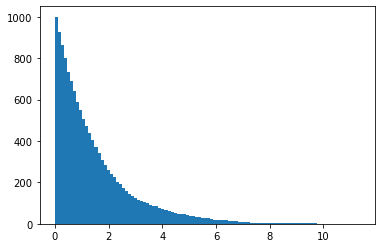

In [172]:
from scipy.stats import expon

dist = expon(loc = 0, scale = 1/np.log(2))
random_times = dist.rvs(size = 1000)
x = np.linspace(0,9,1000)
dist_pdf = dist.pdf(x)
plt.hist(random_times, bins = 100, cumulative = -1)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [181]:
from math import atan
import pandas as pd
from scipy import constants as con
alpha_part = 1000
a0 = con.physical_constants['Bohr radius'][0]
Z = 79 
epsilon = con.epsilon_0
e = con.e
E = (7.7 * 10**6)*con.eV

x = np.random.normal(0, a0/100, alpha_part)
y = np.random.normal(0, a0/100, alpha_part)
b = []
theta_values = []

for i in range(alpha_part):
    bvalue = np.sqrt((x[i])**2 + (y[i])**2)
    tan_half_theta = (Z*e**2)/(2*np.pi*epsilon*E*bvalue)
    theta_half = atan(tan_half_theta)
    theta = theta_half * 2
    theta_values.append(theta)

bounce_backs = 0
for i in range(len(theta_values)):
    if theta_values[i] > np.pi/2:
         bounce_backs+=1
            
print('bounce back fraction:', bounce_backs/alpha_part)

bounce back fraction: 0.002


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

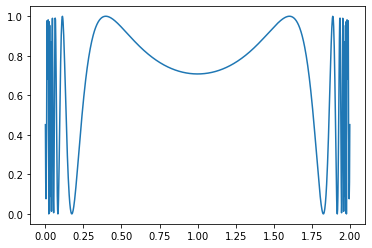

1.450388
0.001


In [88]:
no_points = 1000000

import random 
import math

def function(x):
    return (np.sin(1/(x*(2-x))))**2

a = np.linspace(0.001,1.999,1000)
y = []
# for i in range(1000):
#     y.append(function(a[i]))
plt.plot(a, function(a))
plt.show()
count = 0
hit = 0

while count < no_points:
    x_coord = random.uniform(0,2)
    y_coord = random.uniform(0, 1)
    
    if y_coord < function(x_coord):
        hit += 1
    count += 1
    
total_area = 2 * 1
print((hit/count) * total_area)
error = 1/np.sqrt(no_points)
print(error)

In [89]:
#mean value
#estimate f
number_points = 1000000
f_xi_sum = 0
count = 0
while count < number_points:
    x_coord = random.uniform(0,2)
    f_xi = function(x_coord)
    f_xi_sum = f_xi_sum + f_xi
    f_xis.append(f_xi)
    
    count += 1
    
integral = (2/number_points)*(f_xi_sum)
print(integral)

#very close to value from hit/miss method

1.451996478476829


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



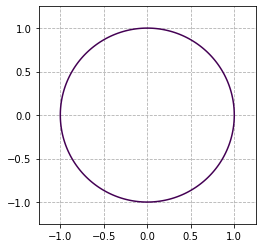

area of circle is 3.14032


In [112]:
def f(x, y):
    if x**2 + y**2 <= 1:
        return 1
    else:
        return 0

x = np.linspace(-1,1,1000)
y = np.linspace(-1,1,1000)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2 - 1
fig, ax = plt.subplots()
ax.contour(X, Y, Z,[0])
ax.set_aspect(1)
plt.grid(linestyle='--')
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.show()
#mean value method
number_points = 1000000
f_xi_sum = 0
count = 0
while count < number_points:
    x_coord = random.uniform(-1,1)
    y_coord = random.uniform(-1,1)
    f_xi = f(x_coord, y_coord)
    f_xi_sum = f_xi_sum + f_xi    
    count += 1
    
integral = (4/number_points)*(f_xi_sum)
print('area of circle is', integral)

In [122]:
#generalise for 10D
def fnD(x):
    if np.inner(x,x) <= 1:
        return 1 
    else:
        return 0
#where x is an n-dimensional vector

#mean value method
number_points = 1000000
f_xi_sum = 0
count = 0
number_dimensions = 10   
x = np.ones(number_dimensions)
print(x)

while count < number_points:
    point = np.random.uniform(-1,1, number_dimensions)
    f_xi = fnD(point)
    f_xi_sum = f_xi_sum + f_xi    
    count += 1
    
integral = ((2**number_dimensions)/number_points)*(f_xi_sum)
print('area of circle is', integral)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
area of circle is 2.552832


In [118]:
#hit miss method
def nSphereVolume(dim, iterations):
    count_in_sphere = 0

    for count_loops in range(iterations):
        point = np.random.uniform(-1.0, 1.0, dim)
        distance = np.linalg.norm(point)
        if distance < 1.0:
            count_in_sphere += 1

    return np.power(2.0, dim) * (count_in_sphere / iterations)

print(nSphereVolume(10, 100000))

2.53952


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

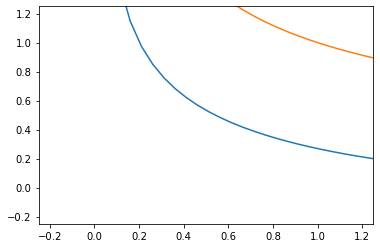

In [183]:
def func(x):
    return x**(-1/2)/(np.exp(x) + 1)
def weighting(x):
    return 1/np.sqrt(x)
num_samples = 1000000
x = np.linspace(0.01,4.99,100)
plt.plot(x, func(x))
#use 1/4x as importance function
plt.plot(x, weighting(x))

plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
plt.show()

In [187]:
lower_bound = 0
upper_bound = 1
sum_of_samples = 0
for i in range(num_samples):
    x = np.random.uniform(0,1)
    sum_of_samples += func(x)
integral = (upper_bound - lower_bound)*(sum_of_samples/num_samples)
print('mean value method:', integral)

#sample y from weighting function 
y = (2*np.random.uniform(0,1,num_samples))**2/4
#integral of w(x) is 2
integral_is = 1.0/num_samples * np.sum(func(y)/weighting(y)) * 2 

print('importance sampling:', integral_is)

mean value method: 0.8368235775759042
importance sampling: 0.8390493273754734
